# Pulse Sequence Creation

In [1]:
import numpy as np
import pulser
from pprint import pprint

## 1. Creating the `Register`

The `Register` defines the positions of the atoms and their names of each one. There are multiple ways of defining a `Register`, the most customizable one being to create a dictionary that associates a name (the key) to a cooordinate (the value).

In [2]:
L = 4
square = np.array([[i, j] for i in range(L) for j in range(L)], dtype=float)
square -= np.mean(square, axis=0)
square *= 5 # if not scaled, it may break!

qubits = dict(enumerate(square))
print(qubits)
reg = pulser.Register(qubits)

{0: array([-7.5, -7.5]), 1: array([-7.5, -2.5]), 2: array([-7.5,  2.5]), 3: array([-7.5,  7.5]), 4: array([-2.5, -7.5]), 5: array([-2.5, -2.5]), 6: array([-2.5,  2.5]), 7: array([-2.5,  7.5]), 8: array([ 2.5, -7.5]), 9: array([ 2.5, -2.5]), 10: array([2.5, 2.5]), 11: array([2.5, 7.5]), 12: array([ 7.5, -7.5]), 13: array([ 7.5, -2.5]), 14: array([7.5, 2.5]), 15: array([7.5, 7.5])}


The `Register` class provides some useful features, like the ability to visualise the array and to make a rotated copy.

The original array:


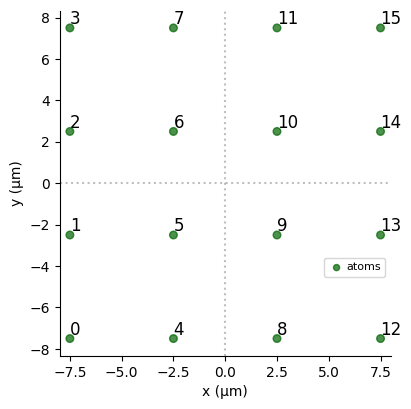

The rotated array:


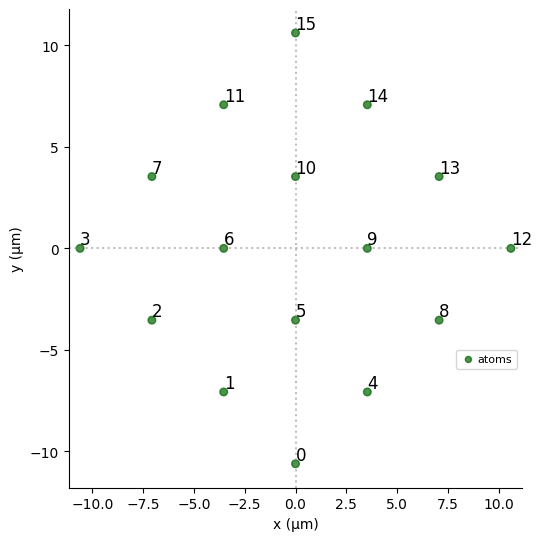

In [3]:
print("The original array:")
reg.draw()
reg1 = reg.rotated(45)  # Rotate by 45 degrees
print("The rotated array:")
reg1.draw()

If one doesn't particularly care about the name given to the qubits, one can also create a `Register` just from a list of coordinates (using the `Register.from_coordinates` class method). In this case, the qubit ID's are just numbered, starting from 0, in the order they are provided in, with the option of adding a common prefix before each number. Also, it automatically centers the entire array around the origin, an option that can be disabled if desired.

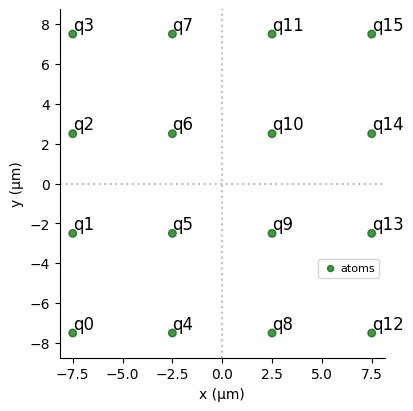

In [4]:
reg2 = pulser.Register.from_coordinates(
    square, prefix="q"
)  # All qubit IDs will start with 'q'
reg2.draw()

Furthermore, there are also built-in class methods from creation of common array patterns, namely:
- Square lattices in rectangular or square shapes
- Triangular lattices

We could, thus, create the same square array as before by doing:

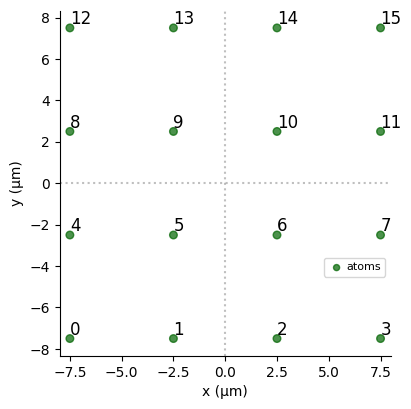

In [5]:
reg3 = pulser.Register.square(4, spacing=5)  # 4x4 array with atoms 5 um apart
# reg3 = pulser.Register.triangular_lattice(4, 4, spacing=1) #rows, atoms_per_row, spacing=4.0, prefix=None
reg3.draw()

## 2. Initializing the Sequence

To create a `Sequence`, one has to provide it with the `Register` instance and the device in which the sequence will be executed. The chosen device will dictate whether the register is valid or not.

We import the device (in this case, `DigitalAnalogDevice`) from `pulser.devices` and initialize our sequence with the freshly created register:

In [6]:
from pulser.devices import DigitalAnalogDevice

seq = pulser.Sequence(reg, DigitalAnalogDevice)

## 3. Declaring the channels that will be used

Inspecting what channels are available on this device:

In [7]:
seq.available_channels

{'rydberg_global': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 15.707963267948966 rad/µs, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg'),
 'rydberg_local': Rydberg.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Minimum retarget time: 220 ns, Fixed retarget time: 0 ns, Max targets: 1, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg'),
 'raman_local': Raman.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Minimum retarget time: 220 ns, Fixed retarget time: 0 ns, Max targets: 1, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'digital'),
 'dmm_0': DMM.Global(Max Absolute Detuning: None, Max Amplitude: 0, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 671088

We're going to choose the `'rydberg_local'` and `'raman_local'` channels. Note how a declared channel is no longer reported as available.

In [16]:
seq.declare_channel("ch0", "raman_local")
print("Available channels after declaring 'ch0':")
pprint(seq.available_channels)

# seq.declare_channel("ch1", "rydberg_local", initial_target=4)
# print("\nAvailable channels after declaring 'ch1':")
# pprint(seq.available_channels)

# seq.declare_channel("ch2", "rydberg_global")
# print("\nAvailable channels after declaring 'ch2':")
# pprint(seq.available_channels)

Available channels after declaring 'ch0':
{'dmm_0': DMM.Global(Max Absolute Detuning: None, Max Amplitude: 0, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg'),
 'rydberg_local': Rydberg.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Minimum retarget time: 220 ns, Fixed retarget time: 0 ns, Max targets: 1, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg')}


At any time, we can also consult which channels were declared, their specifications and the name they were given by calling:

In [9]:
seq.declared_channels

{'ch2': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 15.707963267948966 rad/µs, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Basis: 'ground-rydberg')}

## 4. Composing the Sequence

Every channel needs to start with a target. For `Global` channels this is predefined to be all qubits in the device, but for `Local` channels this has to be defined. This initial target can be set through at channel declaration (see how `'ch1'` was set to target qubit `4`), or it can be done through the standard `target` instruction.

In [17]:
seq.target(1, "ch0")

Now both channels have an initial target, so we can start building the sequence. Let's start by creating a simple pulse with 

- a constant Rabi frequency of 2 rad/µs
- constant detuning of -10 rad/µs
- that lasts 200 ns.

In [18]:
simple_pulse = pulser.Pulse.ConstantPulse(200, 2, -10, 0) # name the parameters

Let's add this pulse to `'ch0'`:

In [21]:
seq.add(simple_pulse, "ch0") # local
seq.add(simple_pulse, "ch2") # global

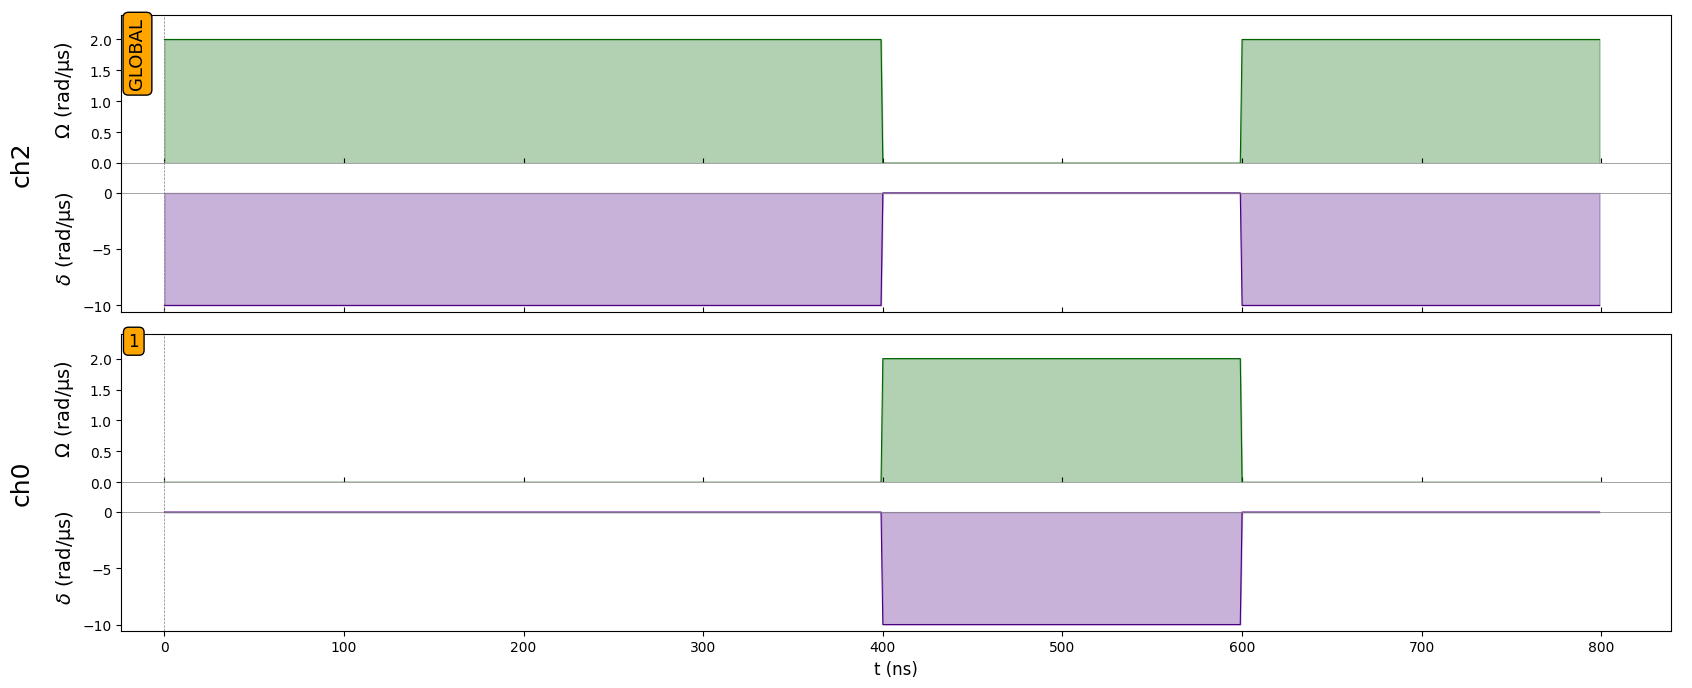

In [22]:
seq.draw()

Now, say we want to idle `'ch1'` for 100 ns while `'ch0'` is doing its pulse. We do that by calling: 

In [ ]:
seq.delay(100, "ch1")

Next, we want to create a more complex pulse to add to `'ch1'`, where the amplitude and the detuning are not constant. To do that, we use `Waveform`s:

In [ ]:
duration = 1000
amp_wf = pulser.BlackmanWaveform(
    duration, np.pi / 2
)  # Duration: 1000 ns, Area: pi/2

detuning_wf = pulser.RampWaveform(
    duration, -20, 20
)  # Duration: 1000ns, linear sweep from -20 to 20 rad/µs

We can visualize a waveform by calling:

In [ ]:
amp_wf.draw()

Also, it is often convenient to find the integral of a waveform, which can be obtain by calling:

In [ ]:
amp_wf.integral  # dimensionless

We then create the pulse with the waveforms instead of fixed values and we can also visualize it:

In [ ]:
complex_pulse = pulser.Pulse(amp_wf, detuning_wf, phase=0)
complex_pulse.draw()

When we're satisfied, we can then add it to a channel:

In [ ]:
seq.add(complex_pulse, "ch1")

Let's check the schedule to see how this is looking:

In [ ]:
print(seq)

We can also draw the sequence, for a more visual representation:

In [ ]:
seq.draw()

Now, let's see how the Sequence builder handles conflicts (i.e. two channels acting on the same qubit at once). We're going to add a `complex_pulse`to `'ch0'`, but now we want to target it to qubit `4`, which is the same target of `'ch1'`.

In [ ]:
seq.target(4, "ch0")
seq.add(complex_pulse, "ch0")

print("Current Schedule:")
print(seq)
seq.draw()

By looking at the current schedule, we can see that `'ch0'` was delayed from `ti=220` to `tf=1100`, and only then was the `complex_pulse` added. The reason for this is simple: it had to wait for the pulse on `ch1`, also targeted to qubit `4`, to finish before it could apply its own. It behaved this way because, in `Sequence.add` there is a default argument `protocol='min-delay`.

Another protocol for pulse addition is `wait-for-all`, which makes the new pulse wait even if there is no conflict. Let's remove the conflict and add two `simple_pulse`s to `ch1` with the different protocols to see how the compare.

In [ ]:
seq.target(0, "ch1")
seq.add(simple_pulse, "ch1", protocol="min-delay")
seq.add(simple_pulse, "ch1", protocol="wait-for-all")

print("Current Schedule:")
print(seq)
seq.draw()

Because we removed the conflict by changing the target of `ch1` to qubit `0`, we see that the first pulse was added without delay from `ti=1100` to `tf=1300` (i.e. while `complex_pulse` is still running in `ch0`). However, once we changed to `protocol='wait-for-all'`, there is now a delay (from `ti=1300` to `tf=2100`) that idles `ch1` until `ch0`is finished with its pulse, even though there was no conflict.

The third protocol is called `'no-delay'` which, as the name implies, never delays the channel where the pulse is being added, even if that means introducing a conflict.

In [ ]:
seq.target(0, "ch0")
seq.add(complex_pulse, "ch0", protocol="no-delay")

print("Current Schedule:")
print(seq)
seq.draw()

With this protocol, it is possible (though not advised), to create an overlap where multiple channels can be acting on the same qubit at the same time. Here, we can see that both act on qubit `0` from `ti=2100` to `tf=2300`.

## 5. Measurement

To finish a sequence, we measure it. A measurement signals the end of a sequence, so after it no more changes are possible. We can measure a sequence by calling:

In [ ]:
DigitalAnalogDevice.supported_bases

In [ ]:
seq.measure(basis="ground-rydberg")

When measuring, one has to select the desired measurement basis. The availabe options depend on the device and can be consulted by calling:

And so, we've obtained the final sequence!

In [ ]:
seq.draw()